c:\Users\guilh\OneDrive\Documents\3A\mention\vision\VisualChess\code


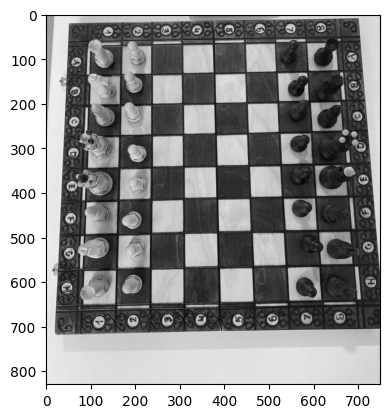

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import os
print(os.getcwd())


def import_image(path):
    img = cv2.imread(path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(img_gray, cmap = 'gray')
    plt.show()

    return img, img_gray

path = '../photos_test/guilhem_board/0_rogned.jpg'
# path = '../photos_test/mathian_board/0.pdf'
# path = '../photos_test/chess.com/0.png'
img, img_gray = import_image(path)


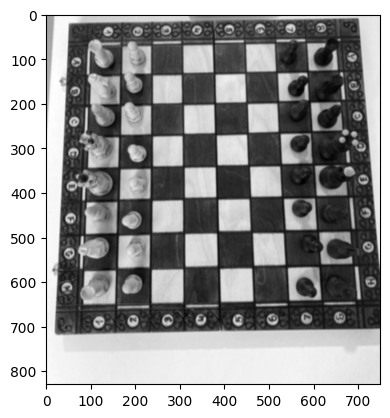

In [27]:
kernel_size = 5
sigma = 1.4

def apply_gaussian_blur(img_gray, kernel_size, sigma):
    gaussian_blur = cv2.GaussianBlur(img_gray, (kernel_size,kernel_size), sigma,sigma,cv2.BORDER_DEFAULT)
    return gaussian_blur

gaussian_blur = apply_gaussian_blur(img_gray, kernel_size, sigma)
plt.imshow(gaussian_blur, cmap = 'gray')
plt.show()

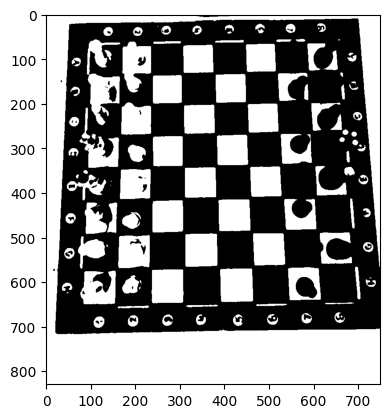

In [28]:
def apply_binary_threshold(img, threshold=128):
    height, width = img.shape
    binary_image = np.copy(img)
    for i in range(height):
        for j in range(width):
            if img[i,j] >=threshold:
                binary_image[i,j] = 255
            else :
                binary_image[i,j] = 0
    return binary_image

threshold = 128
binary_img = apply_binary_threshold(gaussian_blur, threshold)
plt.imshow(binary_img, cmap = 'gray')
plt.show()

# Sobel transformations

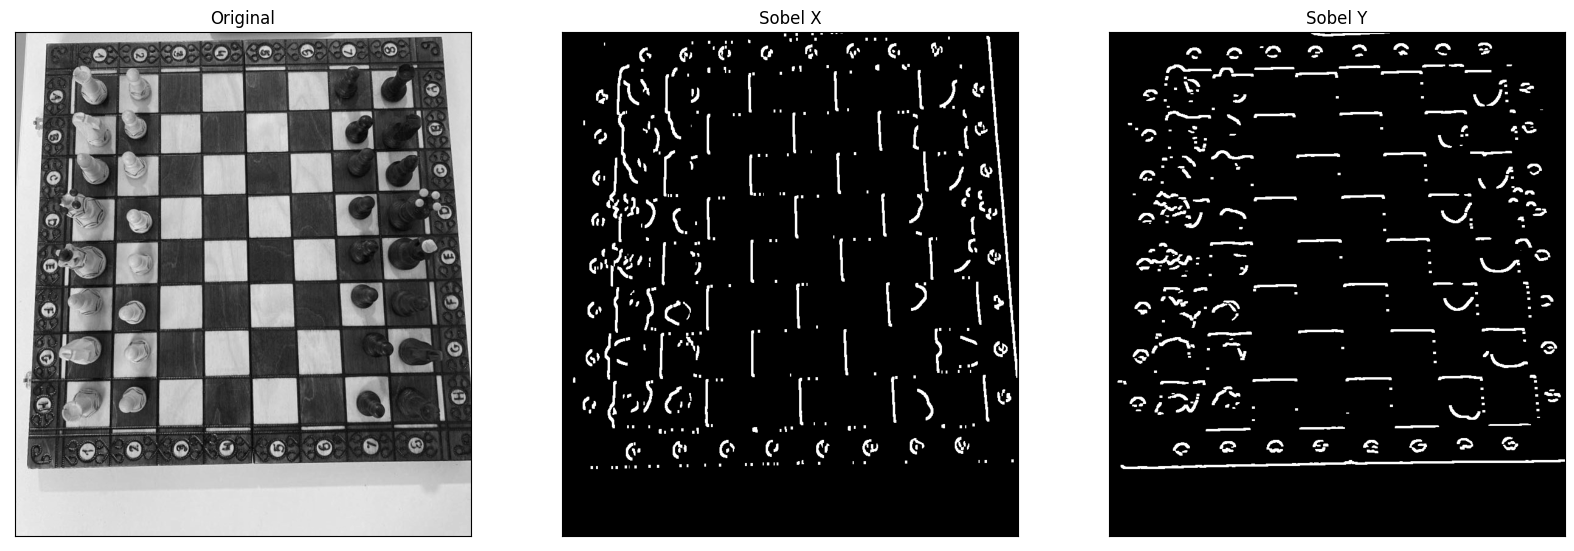

In [29]:
# avec sobel
def get_sobels(binary_img):
    sobelx = cv2.Sobel(binary_img,cv2.CV_8UC1,1,0,ksize=5)
    sobely = cv2.Sobel(binary_img,cv2.CV_8UC1,0,1,ksize=5)
    return sobelx, sobely
 
sobelx, sobely = get_sobels(binary_img)

plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

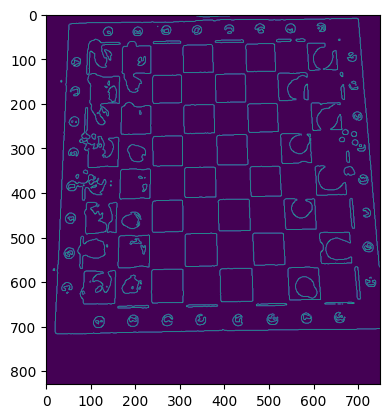

In [30]:
cdst = np.copy(img)

def get_edges(binary_img, threshold1 = 50, threshold2 = 150, apertureSize=3):
    edges = cv2.Canny(binary_img, threshold1, threshold2, apertureSize)
    return edges

edges = get_edges(binary_img)

plt.imshow(edges)
plt.show()


lines = cv2.HoughLines(edges, 1, np.pi / 180, 50, None, 0, 0)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(cdst,(x1,y1),(x2,y2),(0,0,255),2)

In [31]:
def get_points_full_line(l, width, height):
    x1, y1, x2, y2 = l[0], l[1], l[2], l[3]

    if x1 == x2 :
        return (x1, 0), (x2, height)
    
    if y1 == y2 :
        return (0, y1), (width, y1)
    
    slope = (y2 - y1) / (x2 - x1)
    ord_origin = y1 - slope * x1

    if y1 < y2 :
        return (0, round(ord_origin)), (round((height - ord_origin) / slope) , height)
    elif y1 > y2 :
        return (0, round(ord_origin)), (round(( - ord_origin) / slope) , 0)

# test = np.copy(img)
# linesP = [ [[86, 435, 88, 382]], [[409, 10, 460, 2]]]

# # Draw the lines
# if linesP is not None:
#     for i in range(0, len(linesP)):
#         l = linesP[i][0]
#         point1, point2 = get_points_full_line(l, img.shape[1], img.shape[0])
#         print(point1, point2)
#         cv2.line(test, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
#         cv2.line(test, point1, point2, (0,0,255), 3, cv2.LINE_AA)

# plt.imshow(cdstP)



In [32]:
def check_line_already_existing(point1, point2, points, epsilon):
    for (x1, y1), (x2, y2)  in points:
        if np.sqrt((point1[0] -x1)**2 + (point1[1] -y1)**2) < epsilon and np.sqrt((point2[0] -x2)**2 + (point2[1] -y2)**2):
            return True
    return False

def dist(p1, p2):
    return np.sqrt((p1[0]- p2[0])**2 + (p1[1]- p2[1])**2)


def get_intersection_between_2_lines(line1, line2): # line is characterized by two points : line = (p1, p2)
    (x1, y1), (x1prime, y1prime) = line1
    (x2, y2), (x2prime, y2prime) = line2
    if x1 == x1prime:
        if x2 == x2prime:
            return None
        slope2 = (y2 - y2prime) / (x2 - x2prime)
        ord_origin2 = y2 - slope2 * x2
        return (x1, round(slope2 * x1 + ord_origin2))
    elif x2 == x2prime:
        slope1 = (y1 - y1prime) / (x1 - x1prime)
        ord_origin1 = y1 - slope1 * x1
        return (x2, round(slope1 * x2 + ord_origin1))
    else:
        slope1 = (y1 - y1prime) / (x1 - x1prime)
        ord_origin1 = y1 - slope1 * x1
        slope2 = (y2 - y2prime) / (x2 - x2prime)
        ord_origin2 = y2 - slope2 * x2
        if slope1 == slope2:
            return None 
        x_int = - (ord_origin2 - ord_origin1) / (slope2 - slope1)
        y_int = slope1 * x_int + ord_origin1
        return (round(x_int), round(y_int))
    
def get_intersections(points):
    intersections = []
    for i in range(len(points)-1):
        for j in range(i+1, len(points)):
            intersections.append(get_intersection_between_2_lines(points[i], points[j]))
    return intersections



In [33]:
img_lines = np.copy(img)
img_lines_prolonged = np.copy(img)

# Probabilistic Line Transform

def get_houghlines(edges, threshold = 30, probabilistic=True):
    if not probabilistic:
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 50, None, 0, 0)
    else :
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold, None, 50, 10)
    return lines

linesP = get_houghlines(edges)

def get_median_length_linesP(linesP) :
    length_lines = []
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            length_lines.append(dist((l[0],l[1]),(l[2], l[3])))
    return np.median(length_lines)
        

median_length_lines = get_median_length_linesP(linesP)
print(median_length_lines)

points = []
# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        if  median_length_lines - 20 < dist((l[0],l[1]),(l[2], l[3])) < median_length_lines +20 :
            point1, point2 = get_points_full_line(l, img.shape[1], img.shape[0])
            if not check_line_already_existing(point1, point2, points, 30) :
                points.append((point1, point2))
                cv2.line(img_lines_prolonged, point1, point2, (0,0,255), 3, cv2.LINE_AA)  
                cv2.line(img_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

intersections = get_intersections(points)

62.00403199585499


In [34]:
img_intersections = np.copy(img)

for point in intersections:
    if point is not None :
        cv2.circle(img_intersections, (point[0], point[1]), 5, (0, 0, 255), -1)

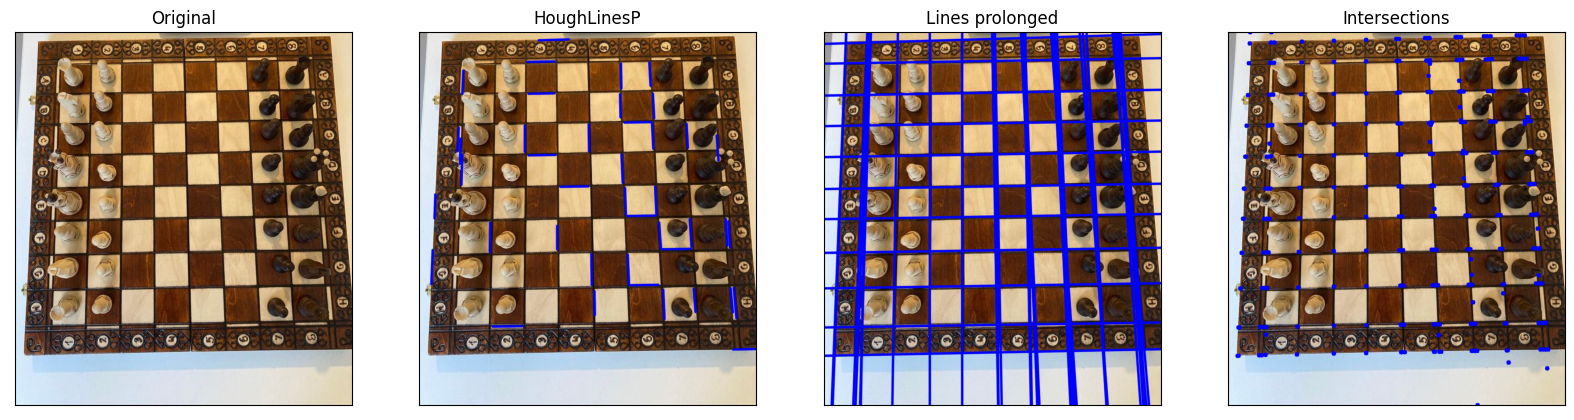

In [35]:
plt.subplots(1, 4, figsize=(20,10))

plt.subplot(1,4,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,2),plt.imshow(img_lines)
plt.title('HoughLinesP'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,3),plt.imshow(img_lines_prolonged)
plt.title('Lines prolonged'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,4),plt.imshow(img_intersections)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

# group intersections


In [36]:
#clean intersections
old_intersections = np.copy(intersections)


def clean_intersections(intersections):
    clean_intersections = []

    for point in intersections:
        if point is None :
            continue
        x, y = point[0], point[1]
        if 0 <= x <= img.shape[1] and 0 <= y <= img.shape[0]:
            clean_intersections.append(point)

    return clean_intersections

intersections_cleaned = clean_intersections(old_intersections)

print(intersections_cleaned)


[(468, 650), (76, 656), (547, 649), (85, 656), (468, 650), (385, 651), (307, 652), (540, 649), (384, 651), (71, 656), (550, 649), (707, 646), (698, 647), (700, 647), (235, 653), (154, 655), (691, 647), (85, 656), (545, 649), (457, 650), (23, 657), (619, 648), (617, 648), (616, 648), (703, 647), (25, 657), (541, 649), (392, 651), (547, 649), (471, 650), (459, 650), (470, 711), (464, 563), (469, 674), (457, 409), (450, 271), (447, 202), (453, 342), (438, 13), (441, 63), (444, 133), (460, 484), (449, 244), (453, 341), (74, 719), (80, 569), (85, 415), (91, 277), (93, 207), (88, 348), (100, 23), (98, 68), (96, 139), (83, 490), (92, 248), (551, 709), (83, 718), (470, 711), (386, 712), (307, 714), (542, 709), (385, 712), (69, 719), (554, 709), (712, 706), (702, 706), (706, 706), (235, 715), (153, 717), (695, 706), (83, 718), (548, 709), (458, 711), (21, 720), (622, 708), (622, 708), (620, 708), (707, 706), (23, 720), (544, 709), (393, 712), (550, 709), (474, 711), (460, 711), (543, 562), (534

In [37]:
def moyenne(points):
    return round(np.mean([point[0] for point in points])), round(np.mean([point[1] for point in points]))

def clusteriser_intersections(intersections, epsilon = 20):
    clusters = {}

    for i, point in enumerate(intersections) :
        if point is None :
            continue
        already_in_cluster = False
        for k in clusters.keys():
            if dist(point, moyenne(clusters[k])) <= epsilon:
                already_in_cluster = True
                clusters[k].append(point)
        if not already_in_cluster:
            clusters[i] = [point]

    return clusters

epsilon_points_clusters = 20
clusters = clusteriser_intersections(intersections_cleaned, epsilon_points_clusters)
print(clusters)

{0: [(468, 650), (468, 650), (457, 650), (471, 650), (459, 650)], 1: [(76, 656), (85, 656), (71, 656), (85, 656), (84, 673)], 2: [(547, 649), (540, 649), (550, 649), (545, 649), (541, 649), (547, 649)], 5: [(385, 651), (384, 651), (392, 651)], 6: [(307, 652)], 11: [(707, 646), (698, 647), (700, 647), (691, 647), (703, 647)], 14: [(235, 653)], 15: [(154, 655)], 20: [(23, 657), (25, 657)], 21: [(619, 648), (617, 648), (616, 648)], 31: [(470, 711), (470, 711), (458, 711), (474, 711), (460, 711)], 32: [(464, 563), (465, 563), (455, 563), (467, 563), (457, 563)], 33: [(469, 674)], 34: [(457, 409), (460, 409), (459, 393), (452, 409), (460, 409), (455, 409)], 35: [(450, 271), (455, 271), (449, 271), (454, 271), (452, 271)], 36: [(447, 202), (453, 201), (448, 202), (451, 201), (451, 201), (451, 206)], 37: [(453, 342), (453, 341), (458, 342), (451, 342), (457, 342), (453, 342)], 38: [(438, 13), (447, 13), (445, 13), (442, 13), (448, 13)], 39: [(441, 63), (448, 63), (449, 70), (446, 63), (445, 6

In [38]:
def group_clusters(clusters):
    new_intersections = []

    for k in clusters.keys():
        new_intersections.append(moyenne(clusters[k]))

    return new_intersections

new_intersections = group_clusters(clusters)

print(new_intersections)
print(len(new_intersections))

[(465, 650), (80, 659), (545, 649), (387, 651), (307, 652), (700, 647), (235, 653), (154, 655), (24, 657), (617, 648), (466, 711), (462, 563), (469, 674), (457, 406), (452, 271), (450, 202), (454, 342), (444, 13), (446, 64), (448, 133), (459, 484), (449, 244), (77, 718), (82, 569), (86, 415), (91, 277), (93, 207), (89, 348), (98, 23), (97, 68), (95, 139), (84, 490), (92, 248), (548, 709), (388, 712), (307, 714), (704, 706), (235, 715), (153, 717), (22, 720), (621, 708), (540, 562), (532, 408), (524, 268), (520, 199), (528, 339), (511, 11), (514, 62), (517, 132), (540, 505), (536, 483), (545, 601), (386, 564), (307, 565), (693, 556), (235, 566), (156, 568), (28, 570), (612, 566), (383, 410), (381, 272), (380, 203), (382, 343), (377, 15), (378, 64), (379, 134), (384, 485), (307, 411), (681, 406), (235, 412), (158, 414), (34, 415), (602, 407), (307, 273), (671, 267), (235, 274), (160, 275), (38, 277), (593, 268), (307, 204), (665, 198), (235, 205), (161, 206), (41, 208), (589, 199), (307,

In [39]:
img_new_intersections = np.copy(img)

for point in new_intersections:
    if point is not None :
        cv2.circle(img_new_intersections, (point[0], point[1]), 5, (0, 0, 255), -1)

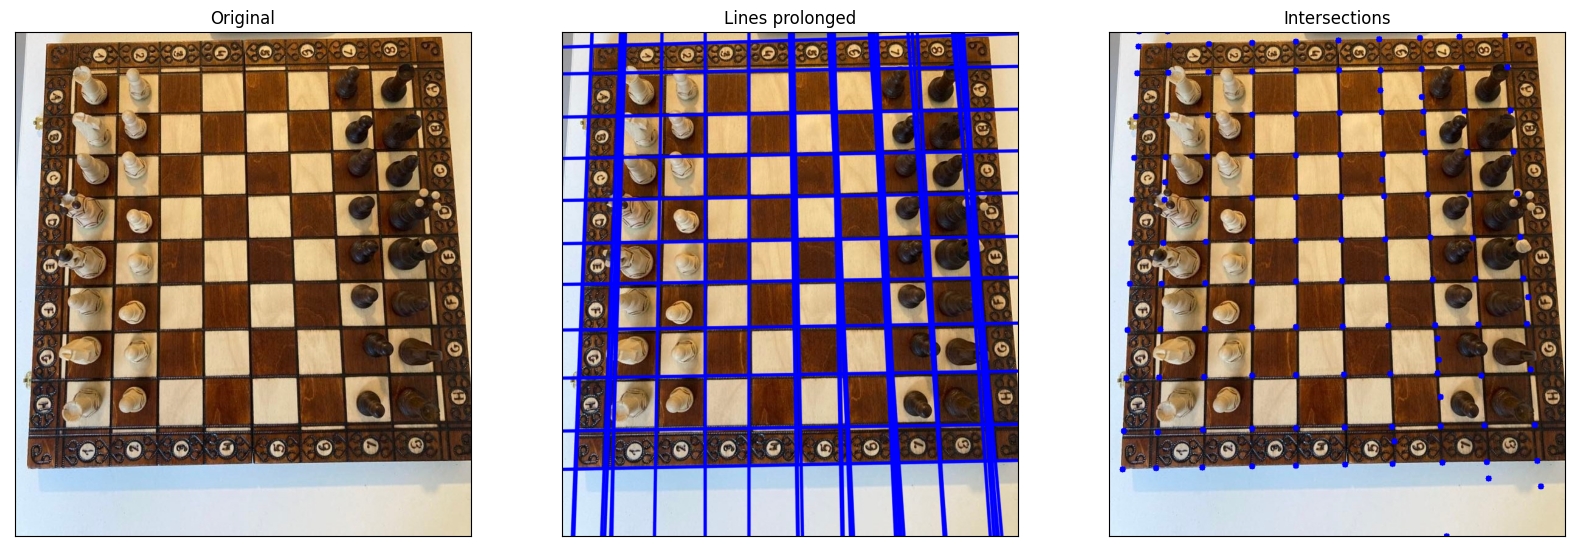

In [40]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(1,3,2),plt.imshow(img_lines)
# plt.title('HoughLinesP'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(img_lines_prolonged)
plt.title('Lines prolonged'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img_new_intersections)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

In [41]:
def moyenne_y(points):
    return round(np.mean([point[1] for point in points]))

def dist_y(y1, y2):
    return np.abs(y1-y2)

## rendu = liste de liste de 4 points

def cluster_along_y(intersections, epsilon = 10):
    clusters_y = {}

    for i, point in enumerate(intersections) :
        already_in_cluster = False
        for k in clusters_y.keys():
            if dist_y(point[1], moyenne_y(clusters_y[k])) <= epsilon:
                already_in_cluster = True
                clusters_y[k].append(point)
        if not already_in_cluster:
            clusters_y[i] = [point]

    return clusters_y

epsilon_clusters_y = 10

clusters_y = cluster_along_y(new_intersections, epsilon_clusters_y)

print(clusters_y)
# for k, v in clusters_y.items():
#     print(k, len(v))


{0: [(465, 650), (80, 659), (545, 649), (387, 651), (307, 652), (700, 647), (235, 653), (154, 655), (24, 657), (617, 648)], 10: [(466, 711), (77, 718), (548, 709), (388, 712), (307, 714), (704, 706), (235, 715), (153, 717), (22, 720), (621, 708)], 11: [(462, 563), (82, 569), (540, 562), (386, 564), (307, 565), (693, 556), (235, 566), (156, 568), (28, 570), (612, 566)], 12: [(469, 674)], 13: [(457, 406), (86, 415), (532, 408), (383, 410), (307, 411), (681, 406), (235, 412), (158, 414), (34, 415), (602, 407)], 14: [(452, 271), (91, 277), (524, 268), (381, 272), (307, 273), (671, 267), (235, 274), (160, 275), (38, 277), (593, 268)], 15: [(450, 202), (93, 207), (520, 199), (380, 203), (307, 204), (665, 198), (235, 205), (161, 206), (41, 208), (589, 199)], 16: [(454, 342), (89, 348), (528, 339), (382, 343), (307, 344), (676, 338), (235, 345), (159, 346), (36, 348), (598, 340)], 17: [(444, 13), (98, 23), (511, 11), (377, 15), (307, 17), (651, 7), (235, 19), (164, 21), (48, 25), (576, 9)], 18

In [42]:
img_anomaly = np.copy(img)
img_non_anomaly = np.copy(img)

def remove_anomalies(clusters_y):
    lines_interests_points_y = {}

    anomaly_points = []
    # non_anomaly_points = []
    for k in clusters_y.keys():
        if len(clusters_y[k]) <=3 :
            for point in clusters_y[k] :
                anomaly_points.append(point)
                cv2.circle(img_anomaly, (point[0], point[1]), 5, (0, 0, 255), -1)

        else :
            lines_interests_points_y[k] = clusters_y[k]
            for point in clusters_y[k] :
                # non_anomaly_points.append(point)
                cv2.circle(img_non_anomaly, (point[0], point[1]), 5, (0, 0, 255), -1)
    
    return lines_interests_points_y, anomaly_points

lines_interests_points_y, anomaly_points = remove_anomalies(clusters_y)


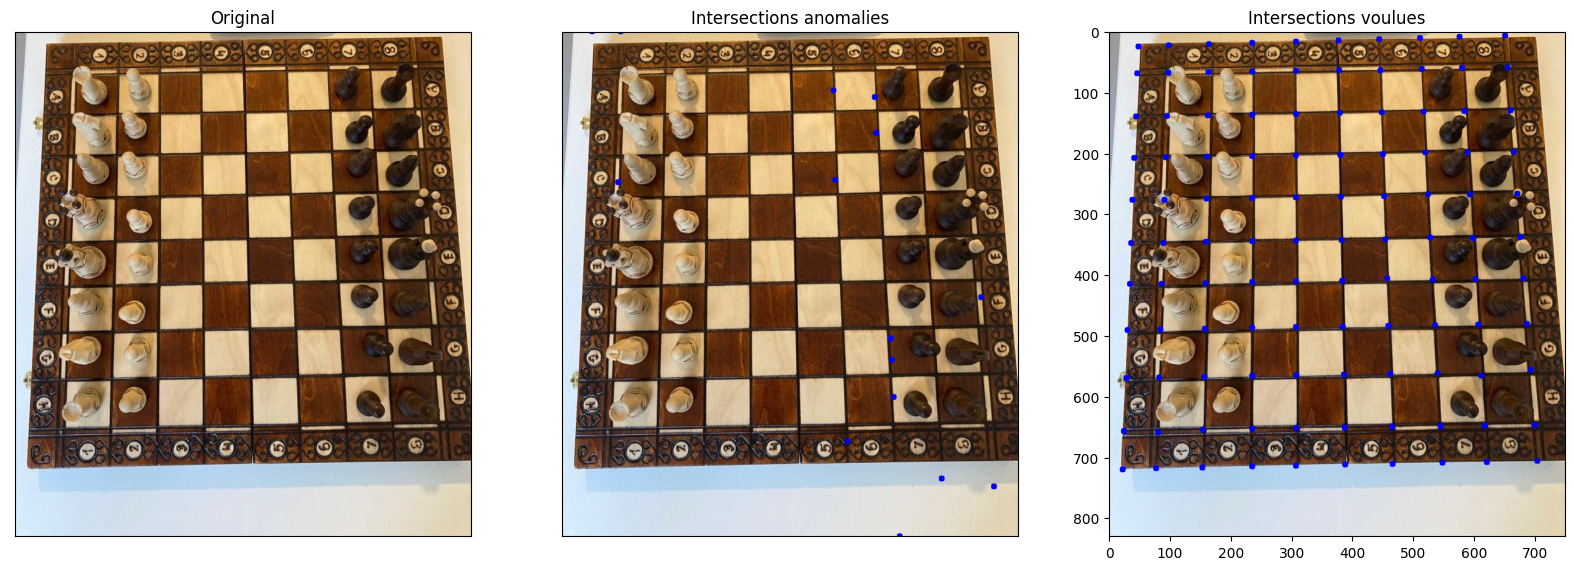

In [43]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(1,3,2),plt.imshow(img_lines)
# plt.title('HoughLinesP'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(img_anomaly)
plt.title('Intersections anomalies'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img_non_anomaly)
plt.title('Intersections voulues'), 
plt.show()

In [44]:
print(lines_interests_points_y)

{0: [(465, 650), (80, 659), (545, 649), (387, 651), (307, 652), (700, 647), (235, 653), (154, 655), (24, 657), (617, 648)], 10: [(466, 711), (77, 718), (548, 709), (388, 712), (307, 714), (704, 706), (235, 715), (153, 717), (22, 720), (621, 708)], 11: [(462, 563), (82, 569), (540, 562), (386, 564), (307, 565), (693, 556), (235, 566), (156, 568), (28, 570), (612, 566)], 13: [(457, 406), (86, 415), (532, 408), (383, 410), (307, 411), (681, 406), (235, 412), (158, 414), (34, 415), (602, 407)], 14: [(452, 271), (91, 277), (524, 268), (381, 272), (307, 273), (671, 267), (235, 274), (160, 275), (38, 277), (593, 268)], 15: [(450, 202), (93, 207), (520, 199), (380, 203), (307, 204), (665, 198), (235, 205), (161, 206), (41, 208), (589, 199)], 16: [(454, 342), (89, 348), (528, 339), (382, 343), (307, 344), (676, 338), (235, 345), (159, 346), (36, 348), (598, 340)], 17: [(444, 13), (98, 23), (511, 11), (377, 15), (307, 17), (651, 7), (235, 19), (164, 21), (48, 25), (576, 9)], 18: [(446, 64), (97,

## Remove chessboard_contours dirty method

In [45]:
# min_key = list(lines_interests_points_y.keys())[0]
# min_mean_y = moyenne_y(lines_interests_points_y[min_key])
# max_key = list(lines_interests_points_y.keys())[0]
# max_mean_y = moyenne_y(lines_interests_points_y[min_key])
# for k in lines_interests_points_y.keys():
#     min_index = lines_interests_points_y[k].index(min(lines_interests_points_y[k], key = lambda x :x[0]))
#     lines_interests_points_y[k].pop(min_index)
#     mean_y = moyenne_y(lines_interests_points_y[k])
#     if mean_y <= min_mean_y:
#         min_key = k
#         min_mean_y = mean_y

#     if mean_y >= max_mean_y:
#         max_key = k
#         max_mean_y = mean_y

# del lines_interests_points_y[min_key]
# del lines_interests_points_y[max_key]



In [46]:
# img_boxes = np.copy(img)

# for k in lines_interests_points_y.keys():
#     for point in lines_interests_points_y[k]:
#         cv2.circle(img_boxes, (point[0], point[1]), 5, (0, 0, 255), -1)

In [47]:
# plt.subplots(1, 2, figsize=(20,10))

# plt.subplot(1,2,1),plt.imshow(img)
# plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(1,2,2),plt.imshow(img_boxes)
# plt.title('Intersections'), plt.xticks([]), plt.yticks([])
# plt.show()

## Sorting 

In [48]:
def sort_lines_of_interest_by_y(lines_interests_points_y):

    # cols = {} 
    cols = []
    moyennes_y = [moyenne_y(lines_interests_points_y[k]) for k in lines_interests_points_y.keys()]
    moyennes_y_sorted =  sorted(moyennes_y)
    print(lines_interests_points_y)

    print(moyennes_y_sorted)

    for i, letter in zip(range(len(moyennes_y)), 'abcdefghijkl'[:len(moyennes_y)]):
        mean = moyennes_y_sorted[i]
        corresponding_k = None
        for k in lines_interests_points_y.keys():
            if moyenne_y(lines_interests_points_y[k]) == mean :
                corresponding_k = k
        # cols[letter] = lines_interests_points_y[corresponding_k]
        cols.append(lines_interests_points_y[corresponding_k])

    # for k in cols.keys():
    for k in range(len(cols)):
        cols[k].sort(key=lambda x : x[0])
    
    return cols

cols_sorted = sort_lines_of_interest_by_y(lines_interests_points_y)
    
print(cols_sorted)

{0: [(465, 650), (80, 659), (545, 649), (387, 651), (307, 652), (700, 647), (235, 653), (154, 655), (24, 657), (617, 648)], 10: [(466, 711), (77, 718), (548, 709), (388, 712), (307, 714), (704, 706), (235, 715), (153, 717), (22, 720), (621, 708)], 11: [(462, 563), (82, 569), (540, 562), (386, 564), (307, 565), (693, 556), (235, 566), (156, 568), (28, 570), (612, 566)], 13: [(457, 406), (86, 415), (532, 408), (383, 410), (307, 411), (681, 406), (235, 412), (158, 414), (34, 415), (602, 407)], 14: [(452, 271), (91, 277), (524, 268), (381, 272), (307, 273), (671, 267), (235, 274), (160, 275), (38, 277), (593, 268)], 15: [(450, 202), (93, 207), (520, 199), (380, 203), (307, 204), (665, 198), (235, 205), (161, 206), (41, 208), (589, 199)], 16: [(454, 342), (89, 348), (528, 339), (382, 343), (307, 344), (676, 338), (235, 345), (159, 346), (36, 348), (598, 340)], 17: [(444, 13), (98, 23), (511, 11), (377, 15), (307, 17), (651, 7), (235, 19), (164, 21), (48, 25), (576, 9)], 18: [(446, 64), (97,

In [49]:
def remove_chessboard_contours(cols_sorted):
    # if len(cols_sorted.keys()) == 9 and len(cols_sorted[list(cols_sorted.keys())[0]]) == 9:
    if len(cols_sorted) == 9 and len(cols_sorted[0]) == 9 :
        return cols_sorted
    
    if len(cols_sorted) == 11 :
        del cols_sorted[0]
        del cols_sorted[-1]

    elif len(cols_sorted) == 10 :
        pass

    for i in range(len(cols_sorted)):
        if len(cols_sorted[i]) == 11 :
            del cols_sorted[i][0]
            del cols_sorted[i][-1]

        elif len(cols_sorted[i]) == 10 :
            nb = len(cols_sorted[i])
            mean_x_distance = np.mean([cols_sorted[i][j+1][0] - cols_sorted[i][j][0] for j in range(nb-1)])
            if cols_sorted[i][1][0] - cols_sorted[i][0][0] < mean_x_distance:
                del cols_sorted[i][0]
            elif cols_sorted[i][-1][0] - cols_sorted[i][-2][0] < mean_x_distance:
                del cols_sorted[i][-1]

    return cols_sorted

cols_sorted = remove_chessboard_contours(cols_sorted)



In [50]:
def get_chessboard_boxes(cols_sorted):
    boxes = {}
    letters = 'abcdefgh'
    nums= '12345678'
    for i in range(8):
        for j in range(8):
            letter = letters[i]
            num = nums[j]
            boxes[letter+num] = [cols_sorted[i][j], cols_sorted[i][j+1], cols_sorted[i+1][j], cols_sorted[i+1][j+1]]

    return boxes

boxes = get_chessboard_boxes(cols_sorted)

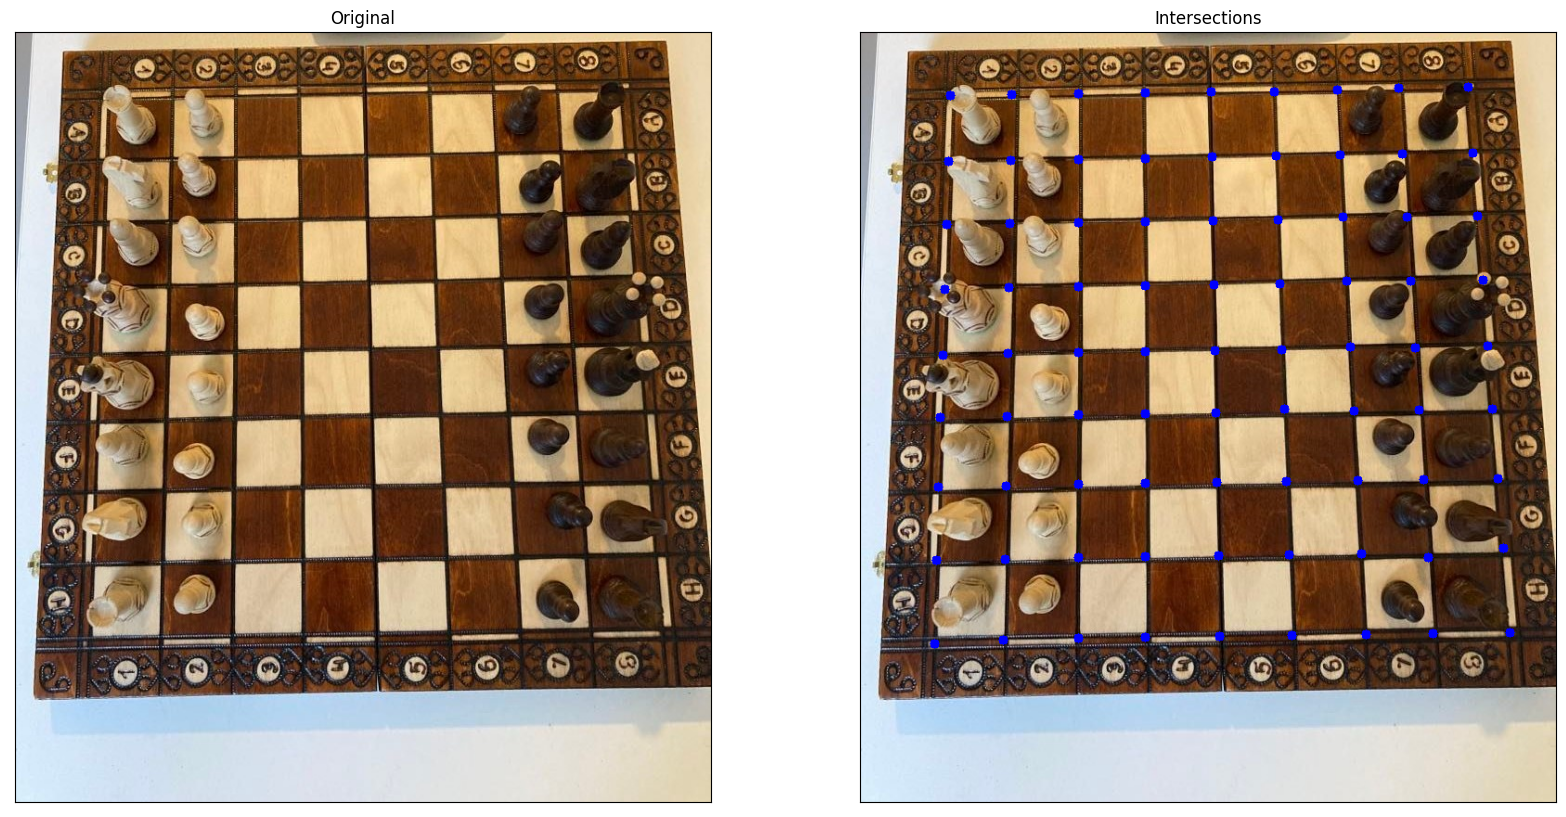

In [51]:
img_copy = np.copy(img)
for line in cols_sorted:
    for point in line :
        cv2.circle(img_copy, (point[0], point[1]), 5, (0, 0, 255), -1)


plt.subplots(1, 2, figsize=(20,10))

plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(img_copy)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

In [52]:
img_boxes_test = np.copy(img)

for point in boxes['e4']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 5, (0, 0, 255), -1)

for point in boxes['h3']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 5, (0, 0, 255), -1)

for point in boxes['b6']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 5, (0, 0, 255), -1)

for point in boxes['f1']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 5, (0, 0, 255), -1)
    

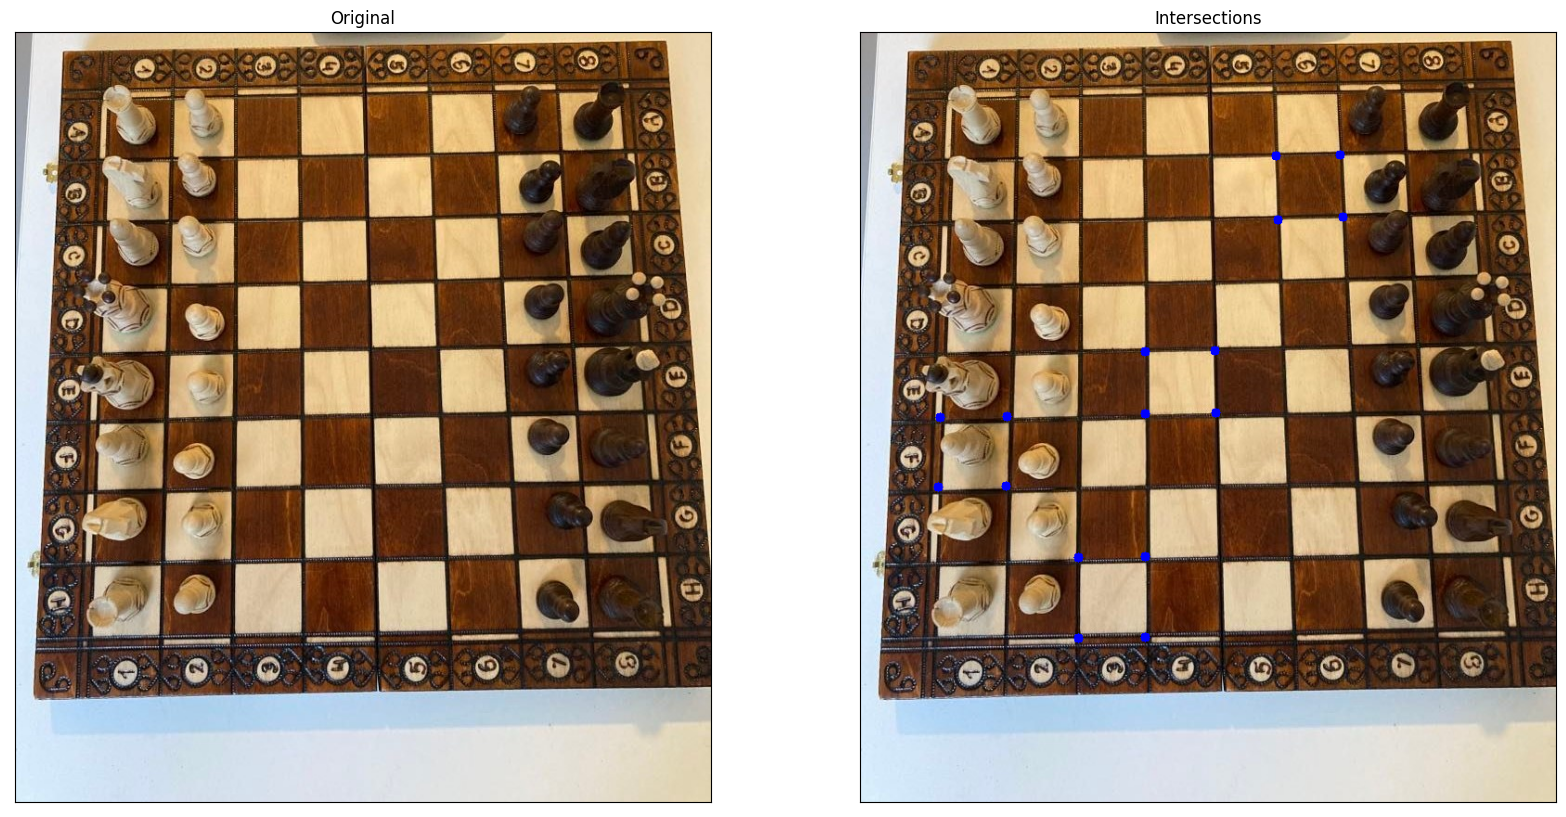

In [53]:
plt.subplots(1, 2, figsize=(20,10))

plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(img_boxes_test)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()